<a href="https://colab.research.google.com/github/rcpaffenroth/PIC-Math-Workshop-on-Data-Science-2022/blob/main/CaseStudy_3_NeuralNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Electric field Measurement ##

This case study is based upon the real world machine learning problem, you can find more detail below:

[Deep Learning for Range Localization via Over-Water Electromagnetic Signals](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9680246)

If you don't have access to IEEE Xplore, you can ask Randy, Patricia, or Mia for the pdf of the paper and they will be happy to send it to you!

**Background:** As a signal moves through the humid air above the ocean, it bounces through layers of humidity known as *evaporation ducts*. This traps and distorts the signal, which you'd think would be bad for us, but it's actually very helpful! This is what allows us to distinguish different signal measurements at different ranges. We have a signal that looks like this:

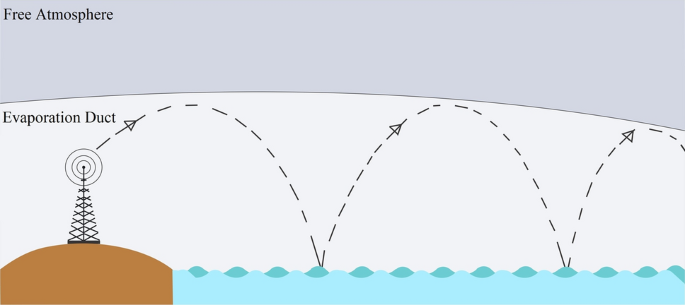


So how do we measure this? Let's imagine there's a boat out on the ocean sending a signal, and we're at a signal receiver on shore. We want to figure out how far away the boat is. In theory, can we even do that?


**Objective:**  Our goal here is to come up with a function that takes in an electromagnetic signal (e.g. radio waves) and outputs the distance that the signal came from.

**Data:** For this problem, our input data is a measurement of the electric field that we see from the transmitter. We measure the electric field with an antenna:

![](https://20fd661yccar325znz1e9bdl-wpengine.netdna-ssl.com/wp-content/uploads/2021/03/best-outdoor-antenna-scaled-e1616606936465.jpeg)

Do you see the 8 X shaped antennae in the image? Each one of those is a signal receiver. We're measuring our signals in a very similar way, except that instead of 8 receivers, we have 40. Additionally, the fact that the receivers are X shaped is a big deal, since they measure our electromagnetical signals at different polarizations. As we know, electromagnetic signals are waves, and can oscillate in any orientation - vertically, horizontally, or anything in between.

![](https://www.specac.com/getattachment/news/calendar/2018/04/polarization-basics/planes-of-polarization.png.aspx?lang=en-GB)

We have to measure both horizontally and vertically to make sure we capture everything - we do this at each of our 40 sensors. Therefore, we essentially have 80 sensors measuring the signal.

Lastly, note that these signals are measured as complex numbers. We don't want to mess around with neural networks of complex numbers, so we will split each complex number into two real numbers before putting them into our data set.

Finally, we end up with 160 dimensional data. So we have 160 features that we can use to predict how far away the transmitter is.

**References:**

Evan Witz, Maria Barger, Randy Paffenroth, Deep Learning for Range Localization via Over-Water Electromagnetic Signals, 2021, ICMLA

### Import Signal Data

In [1]:
# install package

import h5py
import numpy as np
import matplotlib.pylab as py
import random
import datetime
%matplotlib inline

import torch
import torch.optim as optim

import time
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


from numpy import savetxt
from numpy import loadtxt

Similar to case study 1 and 2, the data can be accessed directly by url.

In [2]:
import requests
from pathlib import Path

def download(url: str, output_path: str, mode: str = "wb") -> None:
    res: requests.Response = requests.get(url)
    if Path(output_path).exists():# test if file exists (yu)
        print(f"{output_path} exits")
        return
    if res.status_code != 200:
        raise ValueError(f"download of {url} failed with status code {res.status_code}")
    with open(output_path, mode=mode) as fp:
        fp.write(res.content)


download(
    url="https://raw.githubusercontent.com/rcpaffenroth/PIC-Math-Workshop-on-Data-Science-2022/main/data/cs3data1.h5",
    output_path="./cs3data1.h5",
)
download(
    url="https://raw.githubusercontent.com/rcpaffenroth/PIC-Math-Workshop-on-Data-Science-2022/main/data/cs3data2.h5",
    output_path="./cs3data2.h5",
)

./cs3data1.h5 exits
./cs3data2.h5 exits


We grab the data from the file here.

In [4]:
arrays={}

# grab the data from the file
filepath = ['cs3data1.h5']
# filepath = ['cs3data1.h5', 'cs3data2.h5']
numfiles = len(filepath)
f = 0
for i in range(numfiles):
    f = h5py.File(filepath[i], 'r')
    for k, v in f.items():
        print(k, np.array(v)) # yu: display data in arrays
        arrays[k] = v

# display what data we have
for key in arrays.keys():
    display(key, arrays[key])

duct_height_save [[25.]]
field_H_imag_save [[-5.80410073e-07 -5.99747114e-07 -6.15264080e-07 ...  1.22548960e-07
   1.32640938e-07  1.52684835e-07]
 [-3.69456787e-10  8.69619159e-09  1.44853121e-08 ...  3.94293304e-07
   3.91580215e-07  4.10374175e-07]
 [ 5.80314899e-07  6.14724795e-07  6.39927940e-07 ...  5.30690457e-07
   5.16052868e-07  5.26993916e-07]
 ...
 [ 3.02925520e-07  3.16350720e-07  3.26335034e-07 ...  1.02953636e-07
   9.58462426e-08  9.14152088e-08]
 [ 7.04797337e-08  7.41897729e-08  7.61385835e-08 ...  8.11018381e-08
   7.84890342e-08  7.92711334e-08]
 [-1.84104256e-07 -1.91305910e-07 -1.98010394e-07 ...  3.17629668e-08
   3.44981227e-08  4.01858115e-08]]
field_H_real_save [[-8.86696034e-07 -9.32868276e-07 -9.67202926e-07 ... -5.36046265e-07
  -5.15614626e-07 -5.19317955e-07]
 [-1.06021433e-06 -1.10934670e-06 -1.14657018e-06 ... -3.75402454e-07
  -3.52776078e-07 -3.44476182e-07]
 [-8.87824393e-07 -9.23916239e-07 -9.51904820e-07 ... -9.42178559e-08
  -7.67519964e-08 -5.91

'duct_height_save'

<HDF5 dataset "duct_height_save": shape (1, 1), type "<f8">

'field_H_imag_save'

<HDF5 dataset "field_H_imag_save": shape (1201, 40), type "<f8">

'field_H_real_save'

<HDF5 dataset "field_H_real_save": shape (1201, 40), type "<f8">

'field_V_imag_save'

<HDF5 dataset "field_V_imag_save": shape (1201, 40), type "<f8">

'field_V_real_save'

<HDF5 dataset "field_V_real_save": shape (1201, 40), type "<f8">

'range_grid'

<HDF5 dataset "range_grid": shape (1201, 1), type "<f8">

In [5]:
#numranges = 1201
numranges = len(arrays[key])

# get the electric field data and reshape everything into one np array

data_h_real = np.array(arrays['field_H_real_save']).reshape(numranges, 40)
data_h_imag = np.array(arrays['field_H_imag_save']).reshape(numranges, 40)
data_v_real = np.array(arrays['field_V_real_save']).reshape(numranges, 40)
data_v_imag = np.array(arrays['field_V_imag_save']).reshape(numranges, 40)

Xraw = []
Xraw += [[data_h_real*1, data_h_imag*1, data_v_real*1, data_v_imag*1]]
Xraw = np.block(Xraw)

print(Xraw.shape)

# get the range data
ranges = np.zeros((numranges))
ranges = np.array(arrays['range_grid']).reshape((numranges))

yraw = []
yraw += [ranges]
yraw = np.block(yraw)

print(yraw.shape)

(1201, 160)
(1201,)


### Data preprocessing


Let's take a look at our data points! Here's what an electric field measurement looks like when the transmitter is 15km away, i.e., at a range of 15 km.

441


<Figure size 432x288 with 0 Axes>

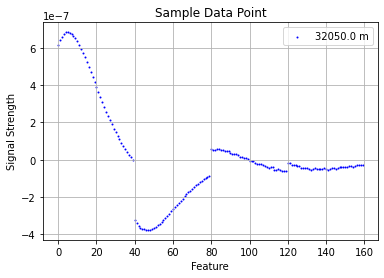

<Figure size 432x288 with 0 Axes>

In [6]:
sample_index=np.random.randint(0,len(Xraw))
print(sample_index)
plt.scatter([range(0,len(Xraw[sample_index]))], Xraw[sample_index], s=1, c='b', label=f"{yraw[sample_index]} m")
plt.grid()
py.xlabel("Feature")
py.ylabel("Signal Strength")
py.title("Sample Data Point")
plt.legend()
plt.figure()

There's one thing that we have to be careful of before attempting to run any algorithm on this data - and that is *data snooping*. Data snooping was mentioned briefly in the first case study. It is very easy to data snoop on this problem because of the fact that electromagnetic signals get weaker the further you are from the transmitter - think of listening to a radio station and the reception getting weaker the further you are from the city the radio station is in.

Imagine the following: we are given many measurements of an electric field coming from a very powerful emitter. Whatever algorithm we use can directly learn that very strong signals are very close to the transmitter, and weaker signals are far from the emitter. Sounds good right? We train a model and it learns to determine distance from the emitter just based on the strength of the signal coming in. But this has a key flaw.

Imagine next that we test our model on a new data point, but this one comes from a very weak emitter. It will take in a weak signal and predict that we are far from the emitter, even though that may not be the case. In practice, we do not know how strong the emitter is that's putting out the signal. This makes our model useless!

To fix this, we must *normalize* the input data, i.e. change all our data vectors to have norm 1. This removes the strength of the signal from our analysis completely, and forces our method to learn based purely on the shape of the data, not its size.

In [8]:
def normalize(X):
  
    normedX = np.zeros_like(X)
    #normalize real (0-79) and img (80, 159) separately
    normedX[:,0:80] = X[:,0:80] / np.linalg.norm(X[:,0:80], axis=1, keepdims=True).reshape((len(X), 1))
    normedX[:,80:160] = X[:,80:160] / np.linalg.norm(X[:,80:160], axis=1, keepdims=True).reshape((len(X), 1))
    #normedX = X / np.linalg.norm(X, axis=1, keepdims=True).reshape((len(X), 1))
    return normedX



In [9]:
x_norm=normalize(Xraw)

<Figure size 432x288 with 0 Axes>

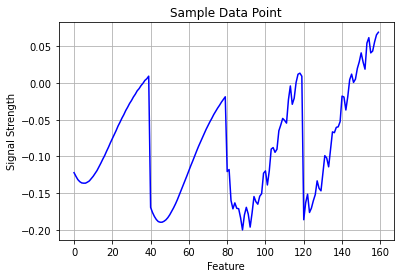

<Figure size 432x288 with 0 Axes>

In [10]:
plt.plot(x_norm[140], c='b')
plt.grid()
py.xlabel("Feature")
py.ylabel("Signal Strength")
py.title("Sample Data Point")
plt.figure()

# Naive solution

### Traditional Regression Modeling

![](https://embarc.online/pluginfile.php/32600/mod_page/content/1/review.jpg)

**Recall:**
Still remember what we did in case study 1? Let's re-implement those algorithms in this case study.

What is the first step? Splitting the training and test set right? 

The `train_test_split` is a function in `sklearn` for the specific purpose of splitting data into train and test sets.


In [11]:
from sklearn.model_selection import train_test_split
XTrain,XTest = train_test_split(x_norm, test_size=0.3, shuffle=True,random_state=1)
yTrain,yTest = train_test_split(yraw, test_size=0.3, shuffle=True,random_state=1)

print(XTrain.shape)
print(XTest.shape)
print(yTrain.shape)
print(yTest.shape)


(840, 160)
(361, 160)
(840,)
(361,)


In [12]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn import linear_model

In [13]:
def train(XTrain,XTest,yTrain,yTest):
    method = linear_model.LinearRegression()
    model = method.fit(XTrain, yTrain)

    y_pred_train=method.predict(XTrain)
    y_pred_test=method.predict(XTest)

    MAE_train=mean_absolute_error(y_pred_train,yTrain)
    MSE_train=mean_squared_error(y_pred_train,yTrain)
    RMSE_train=np.sqrt(mean_squared_error(y_pred_train,yTrain))
    R2_train=r2_score(y_pred_train,yTrain)

    MAE_test=mean_absolute_error(y_pred_test,yTest)
    MSE_test=mean_squared_error(y_pred_test,yTest)
    RMSE_test=np.sqrt(mean_squared_error(y_pred_test,yTest))
    R2_test=r2_score(y_pred_test,yTest)

    return MAE_train,MSE_train,RMSE_train,R2_train,MAE_test,MSE_test,RMSE_test,R2_test

In [14]:
results=[]
from tabulate import tabulate
MAE_train,MSE_train,RMSE_train,R2_train,MAE_test,MSE_test,RMSE_test,R2_test=train(XTrain,XTest,yTrain,yTest)
results.append(["Linear regression",MAE_train,MSE_train,RMSE_train,R2_train,MAE_test,MSE_test,RMSE_test,R2_test])

In [15]:
print (tabulate(results, headers=["Model", "Training MAE", "Training MSE", "Training RMSE", "Training R2", "Test MAE", "Test MSE", "Test RMSE", "Test R2"],tablefmt="grid"))

+-------------------+----------------+----------------+-----------------+---------------+------------+-------------+-------------+------------+
| Model             |   Training MAE |   Training MSE |   Training RMSE |   Training R2 |   Test MAE |    Test MSE |   Test RMSE |    Test R2 |
+===================+================+================+=================+===============+============+=============+=============+============+
| Linear regression |        13150.8 |    2.49155e+08 |         15784.6 |      -3.74118 |    38800.1 | 2.54909e+10 |      159659 | -0.0921414 |
+-------------------+----------------+----------------+-----------------+---------------+------------+-------------+-------------+------------+


## **Question 1** **(20 points)**

**Part 1 (10 points)**
An easy 10 points since we have done this (almost) before :-)
What do MAE, MSE, RMSE and R^2 mean? How are they counted and what is the difference between them? Which is better for describing the performance of your algorithm? Why?

I don't know :D

**Part 2 (10 points)**  

Try at least three different methods such as `KNeighborsRegressor(n_neighbors=20)`, `linear_model.Ridge()`, `linear_model.Lasso()`, or `linear_model.BayesianRidge()`. Can you achieve better performance than the previous model? Report your results in the table below. What are your observations? Please analyze the results.

In [16]:
def train_flexible(method, XTrain,XTest,yTrain,yTest):
#     method = linear_model.LinearRegression()
    model = method.fit(XTrain, yTrain)

    y_pred_train=method.predict(XTrain)
    y_pred_test=method.predict(XTest)

    MAE_train=mean_absolute_error(y_pred_train,yTrain)
    MSE_train=mean_squared_error(y_pred_train,yTrain)
    RMSE_train=np.sqrt(mean_squared_error(y_pred_train,yTrain))
    R2_train=r2_score(y_pred_train,yTrain)

    MAE_test=mean_absolute_error(y_pred_test,yTest)
    MSE_test=mean_squared_error(y_pred_test,yTest)
    RMSE_test=np.sqrt(mean_squared_error(y_pred_test,yTest))
    R2_test=r2_score(y_pred_test,yTest)

    return MAE_train,MSE_train,RMSE_train,R2_train,MAE_test,MSE_test,RMSE_test,R2_test

In [17]:

from tabulate import tabulate
from sklearn.neighbors import KNeighborsRegressor

MAE_train,MSE_train,RMSE_train,R2_train,MAE_test,MSE_test,RMSE_test,R2_test= \
    train_flexible(KNeighborsRegressor(20), XTrain,XTest,yTrain,yTest)
results.append(["KNeighborsRegressor(20)",MAE_train,MSE_train,RMSE_train,R2_train,MAE_test,MSE_test,RMSE_test,R2_test])

MAE_train,MSE_train,RMSE_train,R2_train,MAE_test,MSE_test,RMSE_test,R2_test= \
    train_flexible(linear_model.Ridge(), XTrain,XTest,yTrain,yTest)
results.append(["linear_model.Ridge()",MAE_train,MSE_train,RMSE_train,R2_train,MAE_test,MSE_test,RMSE_test,R2_test])


#print (tabulate(results, headers=["Model", "Training MAE", "Training MSE", "Training RMSE", "Training R2", "Test MAE", "Test MSE", "Test RMSE", "Test R2"],tablefmt="grid"))

In [ ]:
# results.append(["Your ML model 1"," "," "," "," "," "," "," "," "])
# results.append(["Your ML model 2"," "," "," "," "," "," "," "," "])
# results.append(["Your ML model 3"," "," "," "," "," "," "," "," "])

In [18]:
print (tabulate(results, headers=["Model", "Training MAE", "Training MSE", "Training RMSE", "Training R^2", "Test MAE", "Test MSE", "Test RMSE", "Test R^2"],tablefmt="grid"))

+-------------------------+----------------+----------------+-----------------+----------------+------------+-------------+-------------+--------------+
| Model                   |   Training MAE |   Training MSE |   Training RMSE |   Training R^2 |   Test MAE |    Test MSE |   Test RMSE |     Test R^2 |
+=========================+================+================+=================+================+============+=============+=============+==============+
| Linear regression       |       13150.8  |    2.49155e+08 |        15784.6  |      -3.74118  |   38800.1  | 2.54909e+10 |    159659   |   -0.0921414 |
+-------------------------+----------------+----------------+-----------------+----------------+------------+-------------+-------------+--------------+
| KNeighborsRegressor(20) |        6063.38 |    5.52166e+07 |         7430.79 |       0.676931 |    6064.16 | 5.76202e+07 |      7590.8 |    0.667638  |
+-------------------------+----------------+----------------+-----------------+---

# Deep Learning

Now we can move on to deep learning. It's time to train a neural network! Here, we're using a package called PyTorch. It has a lot of built-in tools for coding neural network architechtures and training them. We'll see a few of those in a minute.

![](https://i0.wp.com/semiengineering.com/wp-content/uploads/2018/01/MLvsDL.png?resize=733%2C405&ssl=1)

When training neural networks, we can use different types of hardware and we specify that here. This little bit of code tells PyTorch to figure out whether we're using a GPU or a CPU.

**To use GPU in the colab: Click Runtime (Upper left corner) → Change runtime type → Hardware accelerator → GPU → Save**


In [19]:
device = None
if torch.cuda.is_available():
    print('CUDA available')
    print(torch.cuda.get_device_name(0))
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
else:
    print('CUDA *not* available, use cpu')
    device = torch.device('cpu')


CUDA *not* available, use cpu


## **Question 2** **(15 points)**

Before we move on to model training part, Randy 🧙 wants to ask you several questions. Please read the article below and answer the following questions.

https://www.zendesk.com/blog/machine-learning-and-deep-learning/

https://towardsdatascience.com/what-is-a-gpu-and-do-you-need-one-in-deep-learning-718b9597aa0d

**Part 1 (5 points)**

What are the important things that make deep learning different from other machine learning algorithms?

**Part 2 (5 points)**

What are the differences between a CPU and a GPU? Is the performance of GPU always superior to that of CPU? why?  

**Part 3 (5 points)**  

Why are GPUs particularly effective for performing efficient deep learning? Explain. 

Now we can design a sample neural network architecture here. Let's think about what kind of architecture we want. We know our input is 160 dimensional, so the input to the first layer has to be of size 160. Our output is a single number for a range estimate, so our output has to be 1 dimensional. Everything in between is up to us. And how do we decide what kind of architecture we want? We make it up! At least at first.

This example has 2 layers of size 160 -> 50 -> 1. 

In [20]:
class mynetwork_1(nn.Module):
    def __init__(self):
        super(mynetwork_1, self).__init__()
        self.structure = nn.Sequential(
            nn.Linear(160,50),
            nn.Linear(50, 1)
        )

    def forward(self, x):
        x = self.structure(x)
        return x

In [21]:
class mynetwork_2(nn.Module):
    def __init__(self):
        super(mynetwork_2, self).__init__()
        self.structure = nn.Sequential(
            nn.Linear(160,50),
            nn.Sigmoid(),
            nn.Linear(50, 1)
        )

    def forward(self, x):
        x = self.structure(x)
        return x

## **Question 3** **(5 points)**

**Part 1 (5 points)** 

Comparing the two network structures above, what is the difference between them? In other words, what is `nn.Sigmoid()`, why do we need it? Can both networks perform nonlinearity? why?

Next we need to choose some training settings:

`batch size`

`number of epochs`

`learning rate`

`criterion (loss function)`

## **Question 4** **(10 points)**

Randy 🧙 wants you to know what they are, rather than just arbitarily selecting the numbers. Please read the article below and answer the following questions.

https://blog.paperspace.com/intro-to-optimization-in-deep-learning-gradient-descent/

https://towardsdatascience.com/what-are-hyperparameters-and-how-to-tune-the-hyperparameters-in-a-deep-neural-network-d0604917584a

**Part 1 (5 points)** 

Explain how a neural network optimizes its parameters (weights) using gradient descent. Is it always guaranteed to find the global minimum? Why or why not?

**Part 1 (5 points)** 

What are `batch size`, `number of epochs`, `learning rate`, `criterion (loss function)`? How do they impact the optimization of neural networks?

### **Traning Network**

Now you know what the hyperparameters are. As we might guess, the more epochs we decide to use, the longer it will take and (hopefully) the better accuracy we get. We'll start with 500 epochs in this example. We also have to specify our criterion, or our loss function. The standard method is to use mean squared error (MSE), which is the standard loss function.

In [22]:
torch.manual_seed(50)

# If using a GPU, use option 1, if not, use option 2. (If we using GPU, we need to feed the network into GPU)

# 1
#model_1 = mynetwork_1().cuda()
#model_2 = mynetwork_2().cuda()

# 2
model_1 = mynetwork_1()
model_2 = mynetwork_2()

#training settings
batch_size = 100
num_epochs = 500
learning_rate = 1e-3
criterion = nn.MSELoss()

# print interval during the training 
print_interval=20

In [23]:
def train(training_inputs, training_outputs, network, epochs, learning_rate, 
          batch_size, loss_function, print_interval):
  
  # convert numpy data to tensor data for pytorch
  train_dataset = torch.utils.data.TensorDataset(torch.FloatTensor(training_inputs),
                                                 torch.Tensor(training_outputs))
  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                             shuffle=True)
  optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate, weight_decay=1e-5)
  track_losses = np.zeros(epochs)

  start = time.time()
  for epoch in range(1, epochs+1):

      for batch_idx, (X, y) in enumerate(train_loader):
          # grab the x's for this batch
          data = X

          # find the predictions f(x) for this batch
          output = network(data.to(device))

          # find the loss
          loss = loss_function(output, y.view([-1, 1]).to(device))

          # compute the gradient and update the network parameters
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

      # housekeeping - keep track of our losses and print them as we go
      training_loss = loss.item()**.5
      track_losses[epoch-1] = training_loss
      if epoch % print_interval == 0:
          print('epoch: %4d training loss:%10.3e time:%7.1f'%(epoch, training_loss, time.time()-start))
      
  return network, track_losses

In [24]:
print("network_1 training")
network_1, losses = train(XTrain, yTrain, model_1, num_epochs, learning_rate, batch_size, criterion, print_interval)
print("network_2 training")
network_2, losses = train(XTrain, yTrain, model_2, num_epochs, learning_rate, batch_size, criterion, print_interval)

network_1 training
epoch:   20 training loss: 4.263e+04 time:    0.1
epoch:   40 training loss: 4.048e+04 time:    0.1
epoch:   60 training loss: 4.525e+04 time:    0.2
epoch:   80 training loss: 4.203e+04 time:    0.3
epoch:  100 training loss: 4.042e+04 time:    0.3
epoch:  120 training loss: 4.332e+04 time:    0.4
epoch:  140 training loss: 4.129e+04 time:    0.5
epoch:  160 training loss: 4.662e+04 time:    0.5
epoch:  180 training loss: 4.106e+04 time:    0.6
epoch:  200 training loss: 4.252e+04 time:    0.6
epoch:  220 training loss: 4.317e+04 time:    0.7
epoch:  240 training loss: 4.766e+04 time:    0.8
epoch:  260 training loss: 4.471e+04 time:    0.8
epoch:  280 training loss: 4.091e+04 time:    0.9
epoch:  300 training loss: 4.128e+04 time:    0.9
epoch:  320 training loss: 4.397e+04 time:    1.0
epoch:  340 training loss: 4.447e+04 time:    1.1
epoch:  360 training loss: 4.447e+04 time:    1.1
epoch:  380 training loss: 4.351e+04 time:    1.2
epoch:  400 training loss: 4.42

### **Evaluation**

Now, we need to evaluate our network.

In [25]:
def model_eva(XTrain,XTest,yTrain,yTest,model):
  XTrain_th=torch.FloatTensor(XTrain)
  XTest_th=torch.FloatTensor(XTest)
  #   XTrain_th=torch.FloatTensor(XTrain).cuda()
  #   XTest_th=torch.FloatTensor(XTest).cuda()
  #yTrain_th=torch.Tensor(yTrain).cuda()
  #yTest_th=torch.Tensor(yTest).cuda()

  yTrain_pred_np=model(XTrain_th).cpu().detach().numpy().reshape(-1)
  yTest_pred_np=model(XTest_th).cpu().detach().numpy().reshape(-1)

  MAE_train=mean_absolute_error(yTrain_pred_np,yTrain)
  MSE_train=mean_squared_error(yTrain_pred_np,yTrain)
  RMSE_train=np.sqrt(mean_squared_error(yTrain_pred_np,yTrain))
  R2_train=r2_score(yTrain_pred_np,yTrain)

  MAE_test=mean_absolute_error(yTest_pred_np,yTest)
  MSE_test=mean_squared_error(yTest_pred_np,yTest)
  RMSE_test=np.sqrt(mean_squared_error(yTest_pred_np,yTest))
  R2_test=r2_score(yTest_pred_np,yTest)

  return MAE_train,MSE_train,RMSE_train,R2_train,MAE_test,MSE_test,RMSE_test,R2_test

In [26]:
MAE_train_nn1,MSE_train_nn1,RMSE_train_nn1,R2_train_nn1,MAE_test_nn1,MSE_test_nn1,RMSE_test_nn1,R2_test_nn1=model_eva(XTrain,XTest,yTrain,yTest,network_1)
MAE_train_nn2,MSE_train_nn2,RMSE_train_nn2,R2_train_nn2,MAE_test_nn2,MSE_test_nn2,RMSE_test_nn2,R2_test_nn2=model_eva(XTrain,XTest,yTrain,yTest,network_2)

results.append(["NN_1",MAE_train_nn1,MSE_train_nn1,RMSE_train_nn1,R2_train_nn1,MAE_test_nn1,MSE_test_nn1,RMSE_test_nn1,R2_test_nn1])
results.append(["NN_2",MAE_train_nn2,MSE_train_nn2,RMSE_train_nn2,R2_train_nn2,MAE_test_nn2,MSE_test_nn2,RMSE_test_nn2,R2_test_nn2])


In [27]:
print (tabulate(results, headers=["Model", "Training MAE", "Training MSE", "Training RMSE", "Training R^2", "Test MAE", "Test MSE", "Test RMSE", "Test R^2"],tablefmt="grid"))

+-------------------------+----------------+----------------+-----------------+----------------+------------+-------------+-------------+----------------+
| Model                   |   Training MAE |   Training MSE |   Training RMSE |   Training R^2 |   Test MAE |    Test MSE |   Test RMSE |       Test R^2 |
+=========================+================+================+=================+================+============+=============+=============+================+
| Linear regression       |       13150.8  |    2.49155e+08 |        15784.6  |   -3.74118     |   38800.1  | 2.54909e+10 |    159659   |   -0.0921414   |
+-------------------------+----------------+----------------+-----------------+----------------+------------+-------------+-------------+----------------+
| KNeighborsRegressor(20) |        6063.38 |    5.52166e+07 |         7430.79 |    0.676931    |    6064.16 | 5.76202e+07 |      7590.8 |    0.667638    |
+-------------------------+----------------+----------------+---------

This result does not seem to be very good, so let's try increasing the number of network layers.

In [29]:
class mynetwork_3(nn.Module):
    def __init__(self):
        super(mynetwork_3, self).__init__()
        self.structure = nn.Sequential(
            nn.Linear(160,100),
            nn.LeakyReLU(),
            nn.Linear(100,80),
            nn.LeakyReLU(),
            nn.Linear(80,50),
            nn.LeakyReLU(),
            nn.Linear(50,1)
        )

    def forward(self, x):
        x = self.structure(x)
        return x

In [30]:
#model_3 = mynetwork_3().cuda()
model_3 = mynetwork_3()
network_3, losses_model3 = train(XTrain, yTrain, model_3, num_epochs, learning_rate, batch_size, criterion, print_interval)

epoch:   20 training loss: 3.622e+04 time:    0.1
epoch:   40 training loss: 1.781e+04 time:    0.2
epoch:   60 training loss: 1.668e+04 time:    0.3
epoch:   80 training loss: 1.131e+04 time:    0.4
epoch:  100 training loss: 1.036e+04 time:    0.5
epoch:  120 training loss: 6.754e+03 time:    0.6
epoch:  140 training loss: 6.319e+03 time:    0.7
epoch:  160 training loss: 4.782e+03 time:    0.8
epoch:  180 training loss: 4.519e+03 time:    0.9
epoch:  200 training loss: 3.306e+03 time:    1.0
epoch:  220 training loss: 3.511e+03 time:    1.1
epoch:  240 training loss: 3.359e+03 time:    1.2
epoch:  260 training loss: 3.305e+03 time:    1.3
epoch:  280 training loss: 2.924e+03 time:    1.4
epoch:  300 training loss: 2.929e+03 time:    1.5
epoch:  320 training loss: 2.714e+03 time:    1.5
epoch:  340 training loss: 2.752e+03 time:    1.6
epoch:  360 training loss: 2.546e+03 time:    1.7
epoch:  380 training loss: 2.417e+03 time:    1.8
epoch:  400 training loss: 2.891e+03 time:    1.9


We can plot the training loss by epochs.

<Figure size 432x288 with 0 Axes>

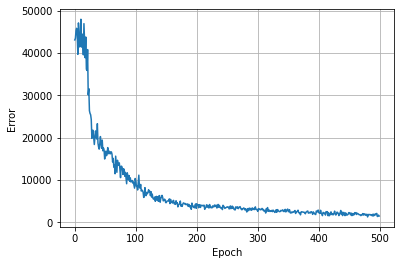

<Figure size 432x288 with 0 Axes>

In [31]:
plt.plot(losses_model3)
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Error")

plt.figure()

In [32]:
MAE_train_nn3,MSE_train_nn3,RMSE_train_nn3,R2_train_nn3,MAE_test_nn3,MSE_test_nn3,RMSE_test_nn3,R2_test_nn3=model_eva(XTrain,XTest,yTrain,yTest,network_3)
results.append(["NN_3",MAE_train_nn3,MSE_train_nn3,RMSE_train_nn3,R2_train_nn3,MAE_test_nn3,MSE_test_nn3,RMSE_test_nn3,R2_test_nn3])
print (tabulate(results, headers=["Model", "Training MAE", "Training MSE", "Training RMSE", "Training R^2", "Test MAE", "Test MSE", "Test RMSE", "Test R^2"],tablefmt="grid"))

+-------------------------+----------------+----------------+-----------------+----------------+------------+-------------+-------------+----------------+
| Model                   |   Training MAE |   Training MSE |   Training RMSE |   Training R^2 |   Test MAE |    Test MSE |   Test RMSE |       Test R^2 |
+=========================+================+================+=================+================+============+=============+=============+================+
| Linear regression       |       13150.8  |    2.49155e+08 |        15784.6  |   -3.74118     |   38800.1  | 2.54909e+10 |   159659    |   -0.0921414   |
+-------------------------+----------------+----------------+-----------------+----------------+------------+-------------+-------------+----------------+
| KNeighborsRegressor(20) |        6063.38 |    5.52166e+07 |         7430.79 |    0.676931    |    6064.16 | 5.76202e+07 |     7590.8  |    0.667638    |
+-------------------------+----------------+----------------+---------

In [33]:
class mynetwork_yu_lrelu(nn.Module):
    def __init__(self):
        super(mynetwork_yu_lrelu, self).__init__()
        self.structure = nn.Sequential(
            nn.Linear(160,100),
            #nn.LeakyReLU(),
            nn.ReLU(),
            nn.Linear(100,80),
            #nn.LeakyReLU(),
            nn.ReLU(),
            nn.Linear(80,50),
            #nn.LeakyReLU(),
            nn.ReLU(),
            nn.Linear(50,1)
        )

    def forward(self, x):
        x = self.structure(x)
        return x

model_yu_lrelu = mynetwork_yu_lrelu()
network_yu_lrelu, losses_yu_lrelu = train(XTrain, yTrain, model_yu_lrelu, num_epochs, learning_rate, batch_size, criterion, print_interval)


epoch:   20 training loss: 3.259e+04 time:    0.1
epoch:   40 training loss: 2.002e+04 time:    0.2
epoch:   60 training loss: 1.444e+04 time:    0.3
epoch:   80 training loss: 1.180e+04 time:    0.5
epoch:  100 training loss: 1.000e+04 time:    0.6
epoch:  120 training loss: 8.242e+03 time:    0.7
epoch:  140 training loss: 6.606e+03 time:    0.8
epoch:  160 training loss: 5.337e+03 time:    0.9
epoch:  180 training loss: 4.729e+03 time:    1.0
epoch:  200 training loss: 4.523e+03 time:    1.1
epoch:  220 training loss: 4.358e+03 time:    1.2
epoch:  240 training loss: 3.812e+03 time:    1.3
epoch:  260 training loss: 3.380e+03 time:    1.4
epoch:  280 training loss: 3.748e+03 time:    1.5
epoch:  300 training loss: 2.570e+03 time:    1.6
epoch:  320 training loss: 3.416e+03 time:    1.7
epoch:  340 training loss: 2.947e+03 time:    1.9
epoch:  360 training loss: 2.873e+03 time:    2.0
epoch:  380 training loss: 3.212e+03 time:    2.1
epoch:  400 training loss: 3.225e+03 time:    2.2


In [34]:
class mynetwork_yu_sig(nn.Module):
    def __init__(self):
        super(mynetwork_yu_sig, self).__init__()
        self.structure = nn.Sequential(
            nn.Linear(160,100),
            #nn.LeakyReLU(),
            nn.Sigmoid(),
            nn.Linear(100,80),
            #nn.LeakyReLU(),
            nn.Sigmoid(),
            nn.Linear(80,50),
            #nn.LeakyReLU(),
            nn.Sigmoid(),
            nn.Linear(50,1)
        )

    def forward(self, x):
        x = self.structure(x)
        return x

model_yu_sig = mynetwork_yu_sig()
mynetwork_yu_sig, losses_yu_sig = train(XTrain, yTrain, model_yu_sig, num_epochs, learning_rate, batch_size, criterion, print_interval)


epoch:   20 training loss: 4.263e+04 time:    0.1
epoch:   40 training loss: 4.289e+04 time:    0.2
epoch:   60 training loss: 4.199e+04 time:    0.3
epoch:   80 training loss: 4.422e+04 time:    0.4
epoch:  100 training loss: 4.296e+04 time:    0.5
epoch:  120 training loss: 3.997e+04 time:    0.7
epoch:  140 training loss: 3.741e+04 time:    0.8
epoch:  160 training loss: 4.717e+04 time:    0.9
epoch:  180 training loss: 3.992e+04 time:    1.0
epoch:  200 training loss: 4.332e+04 time:    1.1
epoch:  220 training loss: 4.496e+04 time:    1.2
epoch:  240 training loss: 4.505e+04 time:    1.3
epoch:  260 training loss: 4.395e+04 time:    1.4
epoch:  280 training loss: 4.165e+04 time:    1.5
epoch:  300 training loss: 4.521e+04 time:    1.6
epoch:  320 training loss: 4.628e+04 time:    1.7
epoch:  340 training loss: 3.792e+04 time:    1.8
epoch:  360 training loss: 4.559e+04 time:    1.9
epoch:  380 training loss: 4.146e+04 time:    2.0
epoch:  400 training loss: 4.806e+04 time:    2.2


<Figure size 432x288 with 0 Axes>

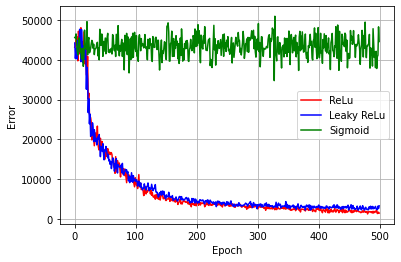

<Figure size 432x288 with 0 Axes>

In [35]:

plt.plot(losses_model3,'r',label='ReLu')
plt.plot(losses_yu_lrelu,'b',label='Leaky ReLu')
plt.plot(losses_yu_sig,'g',label='Sigmoid')
plt.grid()
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.figure()

In [ ]:
MAE_train_nn3,MSE_train_nn3,RMSE_train_nn3,R2_train_nn3,MAE_test_nn3,MSE_test_nn3,RMSE_test_nn3,R2_test_nn3=model_eva(XTrain,XTest,yTrain,yTest,network_3)
results.append(["network_yu1 relu",MAE_train_nn3,MSE_train_nn3,RMSE_train_nn3,R2_train_nn3,MAE_test_nn3,MSE_test_nn3,RMSE_test_nn3,R2_test_nn3])
print (tabulate(results, headers=["Model", "Training MAE", "Training MSE", "Training RMSE", "Training R^2", "Test MAE", "Test MSE", "Test RMSE", "Test R^2"],tablefmt="grid"))

## My part 

## 1. Change Loss Function

In [53]:
torch.manual_seed(50)

# 2
model_1 = mynetwork_1()
model_2 = mynetwork_2()

#training settings
batch_size = 100
num_epochs = 500
learning_rate = 1e-3
criterion = nn.MSELoss()

# print interval during the training 
print_interval=20

In [57]:
# https://medium.com/udacity-pytorch-challengers/a-brief-overview-of-loss-functions-in-pytorch-c0ddb78068f7
print_interval=50
num_epochs=1000
model_3_0 = mynetwork_3()
model_3_1 = mynetwork_3()
model_3_2 = mynetwork_3()
model_3_3 = mynetwork_3()
criterion0=nn.MSELoss()
criterion1=nn.L1Loss() # Mean Absolute Error
criterion2=nn.SmoothL1Loss()
criterion3=nn.CrossEntropyLoss()
print('training criterion original')
model_3_0, losses_3_0 = train(XTrain, yTrain, model_3_0, num_epochs, learning_rate, batch_size, criterion0, print_interval)
print('training criterion1')
model_3_1, losses_3_1 = train(XTrain, yTrain, model_3_1, num_epochs, learning_rate, batch_size, criterion1, print_interval)
print('training criterion2')
model_3_2, losses_3_2 = train(XTrain, yTrain, model_3_2, num_epochs, learning_rate, batch_size, criterion2, print_interval)
print('training criterion3')
model_3_3, losses_3_3 = train(XTrain, yTrain, model_3_3, num_epochs, learning_rate, batch_size, criterion3, print_interval)


training criterion original
epoch:   50 training loss: 1.732e+04 time:    0.3
epoch:  100 training loss: 7.447e+03 time:    0.5
epoch:  150 training loss: 5.003e+03 time:    0.7
epoch:  200 training loss: 3.990e+03 time:    1.0
epoch:  250 training loss: 3.472e+03 time:    1.2
epoch:  300 training loss: 2.675e+03 time:    1.5
epoch:  350 training loss: 2.632e+03 time:    1.7
epoch:  400 training loss: 2.561e+03 time:    2.0
epoch:  450 training loss: 1.863e+03 time:    2.2
epoch:  500 training loss: 1.800e+03 time:    2.4
epoch:  550 training loss: 1.674e+03 time:    2.7
epoch:  600 training loss: 1.485e+03 time:    2.9
epoch:  650 training loss: 1.211e+03 time:    3.2
epoch:  700 training loss: 9.419e+02 time:    3.4
epoch:  750 training loss: 8.718e+02 time:    3.6
epoch:  800 training loss: 5.870e+02 time:    3.9
epoch:  850 training loss: 5.152e+02 time:    4.1
epoch:  900 training loss: 5.610e+02 time:    4.4
epoch:  950 training loss: 4.001e+02 time:    4.6
epoch: 1000 training l

<Figure size 432x288 with 0 Axes>

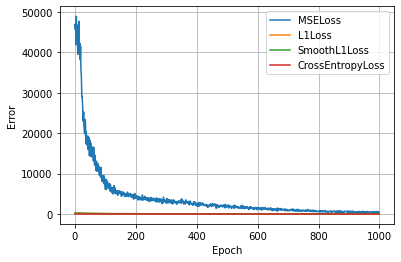

<Figure size 432x288 with 0 Axes>

In [59]:
plt.plot(losses_3_0,label='MSELoss')
plt.plot(losses_3_1,label='L1Loss')
plt.plot(losses_3_2,label='SmoothL1Loss')
plt.plot(losses_3_3,label='CrossEntropyLoss')
# plt.plot(losses_yu_lrelu,'b',label='Leaky ReLu')
# plt.plot(losses_yu_sig,'g',label='Sigmoid')
plt.grid()
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.figure()

In [60]:
results=[]

# original
MAE_train_nn3,MSE_train_nn3,RMSE_train_nn3,R2_train_nn3,MAE_test_nn3,MSE_test_nn3,RMSE_test_nn3,R2_test_nn3=model_eva(XTrain,XTest,yTrain,yTest,model_3_0)
results.append(["MSE",MAE_train_nn3,MSE_train_nn3,RMSE_train_nn3,R2_train_nn3,MAE_test_nn3,MSE_test_nn3,RMSE_test_nn3,R2_test_nn3])

# 1
MAE_train_nn3,MSE_train_nn3,RMSE_train_nn3,R2_train_nn3,MAE_test_nn3,MSE_test_nn3,RMSE_test_nn3,R2_test_nn3=model_eva(XTrain,XTest,yTrain,yTest,model_3_1)
results.append(["L1",MAE_train_nn3,MSE_train_nn3,RMSE_train_nn3,R2_train_nn3,MAE_test_nn3,MSE_test_nn3,RMSE_test_nn3,R2_test_nn3])

# 2
MAE_train_nn3,MSE_train_nn3,RMSE_train_nn3,R2_train_nn3,MAE_test_nn3,MSE_test_nn3,RMSE_test_nn3,R2_test_nn3=model_eva(XTrain,XTest,yTrain,yTest,model_3_2)
results.append(["SmoothL1",MAE_train_nn3,MSE_train_nn3,RMSE_train_nn3,R2_train_nn3,MAE_test_nn3,MSE_test_nn3,RMSE_test_nn3,R2_test_nn3])

# 3
MAE_train_nn3,MSE_train_nn3,RMSE_train_nn3,R2_train_nn3,MAE_test_nn3,MSE_test_nn3,RMSE_test_nn3,R2_test_nn3=model_eva(XTrain,XTest,yTrain,yTest,model_3_3)
results.append(["CrossEntropy",MAE_train_nn3,MSE_train_nn3,RMSE_train_nn3,R2_train_nn3,MAE_test_nn3,MSE_test_nn3,RMSE_test_nn3,R2_test_nn3])


print (tabulate(results, headers=["Model", "Training MAE", "Training MSE", "Training RMSE", "Training R^2", "Test MAE", "Test MSE", "Test RMSE", "Test R^2"],tablefmt="grid"))

+--------------+----------------+------------------+-----------------+----------------+------------+------------------+-------------+------------+
| Model        |   Training MAE |     Training MSE |   Training RMSE |   Training R^2 |   Test MAE |         Test MSE |   Test RMSE |   Test R^2 |
+==============+================+==================+=================+================+============+==================+=============+============+
| MSE          |        303.435 | 168268           |         410.205 |       0.999442 |    608.74  | 765278           |     874.802 |   0.997427 |
+--------------+----------------+------------------+-----------------+----------------+------------+------------------+-------------+------------+
| L1           |        262.089 | 259780           |         509.686 |       0.999131 |    587.052 | 908070           |     952.927 |   0.996896 |
+--------------+----------------+------------------+-----------------+----------------+------------+------------------

![](https://media.makeameme.org/created/its-magic.jpg)

Look at this result! Now you know the power of neural networks! But that's not the limit of it. Now it's time to design your own network.

## **Question 5** **(10 points)**

**Part 1 (5 points)** 

You should notice that we have changed the activation function from `nn.Sigmoid()` to `nn.LeakyReLU()`. Please explain the difference between `nn.Sigmoid()`, `nn.LeakyReLU()` and `nn.ReLU()`. What are their advantages and disadvantages?

**Part 1 (5 points)** 

Replace the activation functions in `mynetwork_3()` with `nn.Sigmoid()` and `nn.ReLU()` and report the results in the following table. Which activation function performs best and why?

In [ ]:
results.append(["NN_3_sigmoid"," "," "," "," "," "," "," "," "])
results.append(["NN_3_relu"," "," "," "," "," "," "," "," "])
print (tabulate(results, headers=["Model", "Training MAE", "Training MSE", "Training RMSE", "Training R^2", "Test MAE", "Test MSE", "Test RMSE", "Test R^2"],tablefmt="grid"))

## **Question 6** **(10 points)**

**Part 1 (10 points)** 

Design at least 3 different neural network structures and train them (e.g., different number of network layers, different number of neurons, different activation functions, etc.). Please report your results, you should be able to design one that is superior to `NN_3`. (Hint: You may need to tune your hyperparameters (`batch size`, `number of epochs`, `learning rate`) to get higher performance.)


In [ ]:
results.append(["Your NN 1"," "," "," "," "," "," "," "," "])
results.append(["Your NN 2"," "," "," "," "," "," "," "," "])
results.append(["Your NN 3"," "," "," "," "," "," "," "," "])
print (tabulate(results, headers=["Model", "Training MAE", "Training MSE", "Training RMSE", "Training R^2", "Test MAE", "Test MSE", "Test RMSE", "Test R^2"],tablefmt="grid"))

# Deep Learning + Feature Engineering

Now you know what deep learning is. Can't we do some feature engineering to improve its performance?

![?](https://www.mememaker.net/static/images/memes/4751028.jpg)

Let's take a look at our data points again! Here's what an electric field measurement looks like when the transmitter is 15km away, i.e., at a range of 15 km.

In [ ]:
plt.plot(XTrain[140], c='b')
plt.grid()
py.xlabel("Feature")
py.ylabel("Signal Strength")
py.title("Sample Data Point")
plt.figure()

Now let's take a look at something strange. Here is that same data point overlaid with the very next data point. We would expect these to be nearly identical.

In [ ]:
plt.plot(x_norm[140], c='b', label='Point 1')
plt.plot(x_norm[141], c='r', label='Point 2')
plt.legend()
plt.grid()
py.xlabel("Index")
py.ylabel("Signal Strength")
py.title("Sample Data Points")
plt.figure()

If we really squint we might be able to see some similarity in shape, but really they're very different. This is a problem for network training. What's going on is that we're measuring a signal every 50m when the signal is oscillating at the scale of centimeters. It's as if we're measuring a sin wave at the integers, i.e. sin(1), sin(2), sin(3), etc. It'll look like we're generating random numbers even though we're measuring something specific.

We need to do some feature engineering!

To account for this all we need to do is rotate the complex numbers that make up the vector. What we do is compute the angle of the very first complex entry in the vector. We rotate the entire vector by the exact angle that makes the first entry positive real.

As a formula, we're doing this:

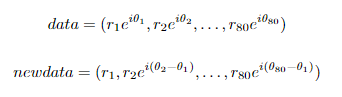

In [ ]:
def rotate(normedX):

    rows = normedX.shape[0]
    cols = normedX.shape[1]
    
    #rotate back
    angle_h = np.arctan(normedX[:,40]/normedX[:,0]).reshape((rows, 1))
    angle_v = np.arctan(normedX[:,120]/normedX[:,80]).reshape((rows, 1))
    
    realparts_h = normedX[:,0:40]
    imagparts_h = normedX[:,40:80]
    
    
    output = np.zeros_like(normedX)
    
    output[:,0:40] = np.cos(angle_h)*realparts_h + np.sin(angle_h) * imagparts_h
    output[:,40:80] = -np.sin(angle_h)*realparts_h + np.cos(angle_h) * imagparts_h
    
    
    realparts_v = normedX[:,80:120]
    imagpart_v = normedX[:,120:160]
    output[:,80:120] = np.cos(angle_v)*realparts_v + np.sin(angle_v) * imagpart_v
    output[:,120:160] = -np.sin(angle_v)*realparts_v + np.cos(angle_v) * imagpart_v
        
    output[:,0:80] = np.sign(output[:,0]).reshape((rows,1)) * output[:,0:80]
    output[:,80:160] = np.sign(output[:,80]).reshape((rows,1)) * output[:,80:160]
    
    return output

Let's take another look at our data once we apply this rotation:

In [ ]:
plt.plot(rotate(x_norm)[140], c='b', label='Point 1')
plt.plot(rotate(x_norm)[141], c='r', label='Point 2')
plt.legend()
plt.grid()
py.xlabel("Index")
py.ylabel("Signal Strength")
py.title("Sample Data Points")
plt.figure()

Now they're nearly identical! This might be good for our network training - it's easier to train if similar inputs lead to similar outputs.

## **Question 7** **(10 points)**

**Part 1 (10 points)** 

Design and train a NN with rotated data `X`, you should be able to get a good result by turning your hyperparameters (`batch size`, `number of epochs`, `learning rate`).

Hint:

XTrain_rotated=rotate(XTrain)

XTest_rotated=rotate(XTest)

model_r = YourNetwork().cuda()

batch_size = 50, 100, 200

num_epochs = 500,1000, 2000

learning_rate = 1e-2, 1e-3, 1e-4

criterion = nn.MSELoss()

network_r, losses = train(XTrain_rotated, yTrain, model_r, num_epochs, learning_rate, batch_size, criterion, print_interval)


In [ ]:
results.append(["Your NN with rotated X"," "," "," "," "," "," "," "," "])
print (tabulate(results, headers=["Model", "Training MAE", "Training MSE", "Training RMSE", "Training R^2", "Test MAE", "Test MSE", "Test RMSE", "Test R^2"],tablefmt="grid"))

# Cross weather evaluation.

Next, we want to see how well this model would perform on new kinds of data. 

There's a huge part of this problem that we haven't discussed yet - the weather conditions make an enormous difference when it comes to the electric field! In particular, the most important of these weather conditions is the evaporation duct we mentioned earlier. Recall that the duct traps the signal, the signal bounces around in the duct, and that allows us to get good range predictions. The key difficulty in this problem is that the electric field you get when the duct is 20 meters tall is very very different from the electric field you get when the duct is 25 meters tall. All the data we've used so far comes from a 25 meter duct.

There's a crucial question here - **if the weather today is different from the weather yesterday, can we still make good range predictions?** 

Imagine the following: we go out one day and collect training data for this problem, and the weather for that day was such that the evaporation duct was 25m tall. We train our neural network and make great predictions. The next day, we try to go out and use our neural network in the field to make range predictions, but the weather is different - the duct height is 24m. Can we still do a good job? We need to figure out what kind of performance we can expect in different weather conditions.

The next file has some electric field data for different weather conditions.

Our previous data set was 1 electric field coming from a duct height of 25m. This next data set has 4 electric fields coming from duct heights of 23, 23.5, 24, and 24.5 meters. Let's test and see how well our network does on these data sets.

Let's load new data for the evaluation.

In [ ]:
arrays2 = {}

filepath = ['cs3data2.h5']
numfiles = len(filepath)
f = 0
for i in range(numfiles):
    f = h5py.File(filepath[i], 'r')
    for k, v in f.items():
        arrays2[k] = v

# display what data we have
for key in arrays2.keys():
    print(key, arrays2[key])

In [ ]:
# what are our new test duct heights?
duct_heights = np.array(arrays2['duct_height_save']).reshape(-1)
print(duct_heights)

In [ ]:
numfields =  4
numranges = 1201

#get the electric field data and reshape everything into one np array

test_data_h_real = np.array(arrays2['field_H_real_save']).reshape(numfields, numranges, 40)
test_data_h_imag = np.array(arrays2['field_H_imag_save']).reshape(numfields, numranges, 40)
test_data_v_real = np.array(arrays2['field_V_real_save']).reshape(numfields, numranges, 40)
test_data_v_imag = np.array(arrays2['field_V_imag_save']).reshape(numfields, numranges, 40)

XTest_otherducts = []
XTest_otherducts += [[test_data_h_real*1, test_data_h_imag*1, test_data_v_real*1, test_data_v_imag*1]]
XTest_otherducts = np.block(XTest_otherducts)
print(XTest_otherducts.shape)

# get the target range data

ranges = np.array(arrays2['range_grid']).reshape((numranges))

yTest_otherducts = []
yTest_otherducts += [ranges]
yTest_otherducts = np.block(yTest_otherducts)
print(yTest_otherducts.shape)

Let test our network on all 4 of these data sets.

In [ ]:
MAE_train_nn3_w1,MSE_train_nn3_w1,RMSE_train_nn3_w1,R2_train_nn3_w1,MAE_test_nn3_w1,MSE_test_nn3_w1,RMSE_test_nn3_w1,R2_test_nn3_w1=model_eva(XTrain,normalize(XTest_otherducts[0]),yTrain,yTest_otherducts,network_3)
MAE_train_nn3_w2,MSE_train_nn3_w2,RMSE_train_nn3_w2,R2_train_nn3_w2,MAE_test_nn3_w2,MSE_test_nn3_w2,RMSE_test_nn3_w2,R2_test_nn3_w2=model_eva(XTrain,normalize(XTest_otherducts[1]),yTrain,yTest_otherducts,network_3)
MAE_train_nn3_w3,MSE_train_nn3_w3,RMSE_train_nn3_w3,R2_train_nn3_w3,MAE_test_nn3_w3,MSE_test_nn3_w3,RMSE_test_nn3_w3,R2_test_nn3_w3=model_eva(XTrain,normalize(XTest_otherducts[2]),yTrain,yTest_otherducts,network_3)
MAE_train_nn3_w4,MSE_train_nn3_w4,RMSE_train_nn3_w4,R2_train_nn3_w4,MAE_test_nn3_w4,MSE_test_nn3_w4,RMSE_test_nn3_w4,R2_test_nn3_w4=model_eva(XTrain,normalize(XTest_otherducts[3]),yTrain,yTest_otherducts,network_3)

In [ ]:
results.append(["NN_3_weather_1",MAE_train_nn3_w1,MSE_train_nn3_w1,RMSE_train_nn3_w1,R2_train_nn3_w1,MAE_test_nn3_w1,MSE_test_nn3_w1,RMSE_test_nn3_w1,R2_test_nn3_w1])
results.append(["NN_3_weather_2",MAE_train_nn3_w2,MSE_train_nn3_w2,RMSE_train_nn3_w2,R2_train_nn3_w2,MAE_test_nn3_w2,MSE_test_nn3_w2,RMSE_test_nn3_w2,R2_test_nn3_w2])
results.append(["NN_3_weather_3",MAE_train_nn3_w3,MSE_train_nn3_w3,RMSE_train_nn3_w3,R2_train_nn3_w3,MAE_test_nn3_w3,MSE_test_nn3_w3,RMSE_test_nn3_w3,R2_test_nn3_w3])
results.append(["NN_3_weather_4",MAE_train_nn3_w4,MSE_train_nn3_w4,RMSE_train_nn3_w4,R2_train_nn3_w4,MAE_test_nn3_w4,MSE_test_nn3_w4,RMSE_test_nn3_w4,R2_test_nn3_w4])

In [ ]:
print (tabulate(results, headers=["Model", "Training MAE", "Training MSE", "Training RMSE", "Training R^2", "Test MAE", "Test MSE", "Test RMSE", "Test R^2"],tablefmt="grid"))

## **Question 8** **(20 points)**

**Part 1 (5 points)** 

What are your observations here? Does the model perform well in all different weather? 


**Part 1 (15 points)** 

Merge all data of different weather together, and then retrain the model. Can you acheive a better performance? Report you results.

Hint:

Using `np.concatenate` to merge to data. eg, XTrain_all = np.concatenate((XTrain1, XTrain2))



In [ ]:
results.append(["Your NN all weather"," "," "," "," "," "," "," "," "])
print (tabulate(results, headers=["Model", "Training MAE", "Training MSE", "Training RMSE", "Training R^2", "Test MAE", "Test MSE", "Test RMSE", "Test R^2"],tablefmt="grid"))

## **Question 9** **($\infty$ points, since this is where you really learn stuff! :-)**

You can get as many points of extra credit as you like by doing a good job with this question!

Play around with doing a better analysis.  Things to try:

1.   We already know the power of neural networks, so is it possible to overfit them? How can we prevent the overfitting of neural networks? There are two common techniques widely used for regularization: Dropout and Batch Normalization. Try to use them in your networks, do the networks perform better than others?
Here are several examples in Pytorch:
https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html,
https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html


2.  The real-world signals are often noisy, can we add Gaussian noise to our training samples to simulate the signal and improve model performance? You might get inspiration from the paper [Deep Learning for Range Localization via Over-Water Electromagnetic Signals](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9680246). Try to do some feature engineering and report your results. If you have any great ideas, please don't hesitate to tell Randy 🧙, he can help you publish a paper at top conferences and shine your resume. 👀




